In [117]:
import os
import random
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("grayscale")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import mean_absolute_error
import keras.backend as K

#import keras_contrib.losses.dssim as ssim

In [20]:
# Set some parameters
im_width = 512
im_height = 512
border = 5
path_train = '/home/nvs/Documents/DB/FLIR/Calib/Sample/'

In [21]:
def get_data(path):
    ids_x = next(os.walk(path + "TRM"))[2]
    ids_x.sort()
    ids_y = next(os.walk(path + "RGB"))[2]
    ids_y.sort()
    X = np.zeros((len(ids_x), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(ids_y), im_height, im_width, 1), dtype=np.float32)
    
    for n, id_x in tqdm_notebook(enumerate(ids_x), total=len(ids_x)):
        id_y = ids_y[n]
        # Load images
        #img = load_img(path + '/TRM/' + id_x, grayscale=True)
        #x_img = img_to_array(img)
        img = cv.imread(path + '/TRM/' + id_x,cv.COLOR_BGR2GRAY)
        x_img = np.array(img)
        x_img = (x_img - x_img.min()) / (x_img.max() - x_img.min())
        x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
        mask = img_to_array(load_img(path + '/RGB/' + id_y, grayscale=True))
        mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
        
        X[n, ..., 0] = x_img.squeeze()
        y[n] = mask / 255
        
    return X, y


X,y = get_data(path_train)


/home/nvs/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/nvs/anaconda3/envs/DeepLearning/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [22]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/3, random_state=2019)

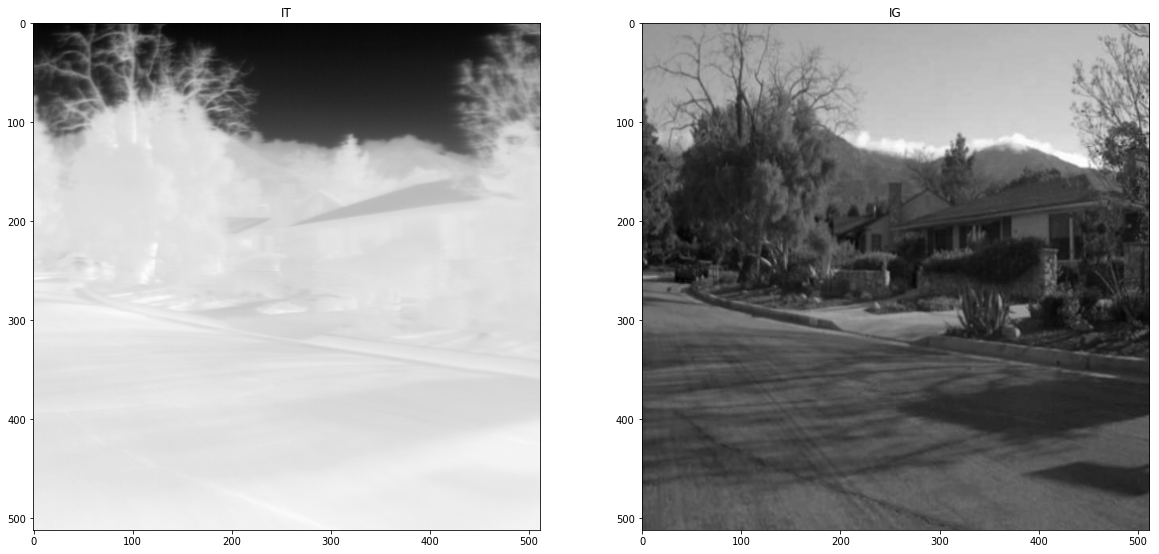

In [23]:
# Check if training data looks all right
ix = random.randint(0, len(X_train)-1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(X_train[ix].squeeze(), cmap='gray', interpolation='bilinear')
ax[0].set_title('IT')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('IG');

In [25]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [98]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    #outputs = Conv2D(1, (1, 1)) (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [118]:
def ssim_tf(ssim_fact=1):
    def ssim_loss(y_true, y_pred):
        return ssim_fact * tf.image.ssim(y_true, y_pred, max_val=1) + (1-ssim_fact) * mean_absolute_error(y_true, y_pred)
    return ssim_loss

In [119]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
ssimTF = ssim_tf(ssim_fact=0.5)
# 'mean_squared_error' 'mean_absolute_error' 'mean_absolute_percentage_error'
model.compile(optimizer=Adam(), loss=ssimTF, metrics=["accuracy"])
# model.summary()

In [127]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     horizontal_flip=True,
                    rotation_range=15,
                    brightness_range=(0.8, 1.2),
                    zoom_range=[0.7, 1.3])

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 2019
bs = 1

image_generator = image_datagen.flow(X_train, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=bs, shuffle=True)

# Just zip the two generators to get a generator that provides augmented images and masks at the same time
train_generator = zip(image_generator, mask_generator)

In [128]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [129]:
#results = model.fit(X_train, y_train, batch_size=2, epochs=1000, callbacks=callbacks)
#results = model.fit(X_train, y_train, batch_size=4, epochs=10, callbacks=callbacks,
#                    validation_data=(X_valid, y_valid))
results = model.fit_generator(train_generator, steps_per_epoch=(len(X_train) // bs), epochs=30, callbacks=callbacks,
                              validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/30
 - 13s - loss: 77.5536 - acc: 0.0000e+00 - val_loss: 1.4165 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.41647, saving model to model-tgs-salt.h5
Epoch 2/30
 - 12s - loss: 80.0154 - acc: 0.0000e+00 - val_loss: 2.7550 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.41647
Epoch 3/30
 - 14s - loss: 77.0474 - acc: 0.0000e+00 - val_loss: 2.2144 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.41647
Epoch 4/30
 - 14s - loss: 83.8159 - acc: 0.0000e+00 - val_loss: 0.8289 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 1.41647 to 0.82890, saving model to model-tgs-salt.h5
Epoch 5/30
 - 14s - loss: 79.6101 - acc: 0.0000e+00 - val_loss: 0.8787 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve from 0.82890
Epoch 6/30
 - 14s - loss: 85.9514 - acc: 0.0000e+00 - val_loss: 0.9554 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve from 0.82890
Epoch 7/30
 - 15s - loss: 77.3873 - acc: 0.0000e+00 - va

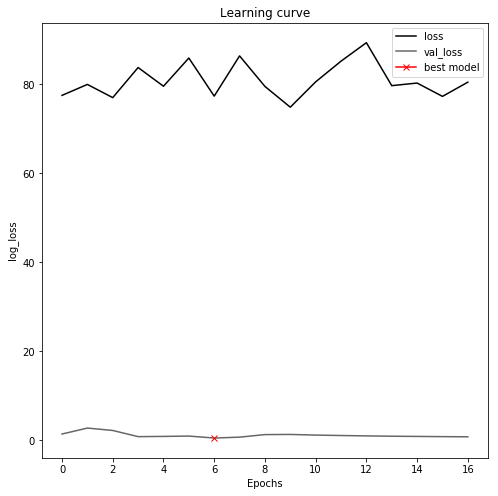

In [130]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [133]:
# Load best model
model.load_weights('model-tgs-salt.h5')


In [134]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

InvalidArgumentError: Incompatible shapes: [2] vs. [2,512,512]
	 [[{{node loss_13/conv2d_323_loss/ArithmeticOptimizer/HoistCommonFactor_Add_add_7}}]]

In [135]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

2/2 [==============================] - 1s 460ms/step


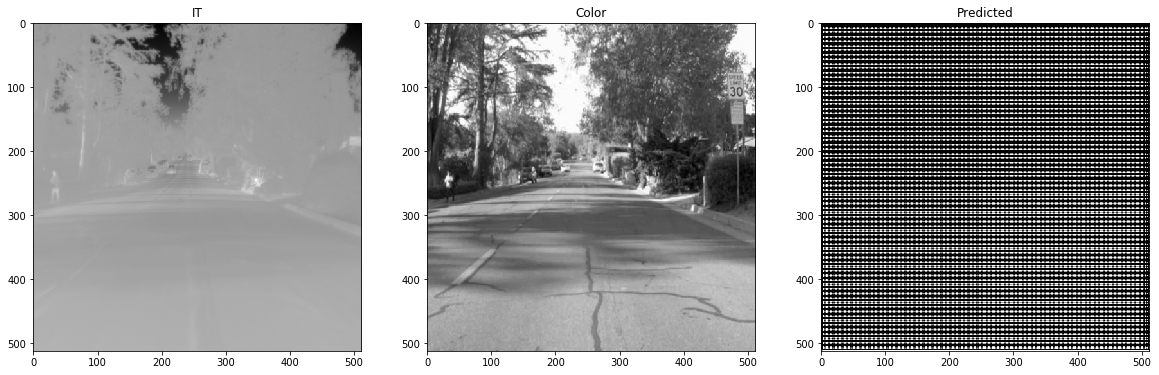

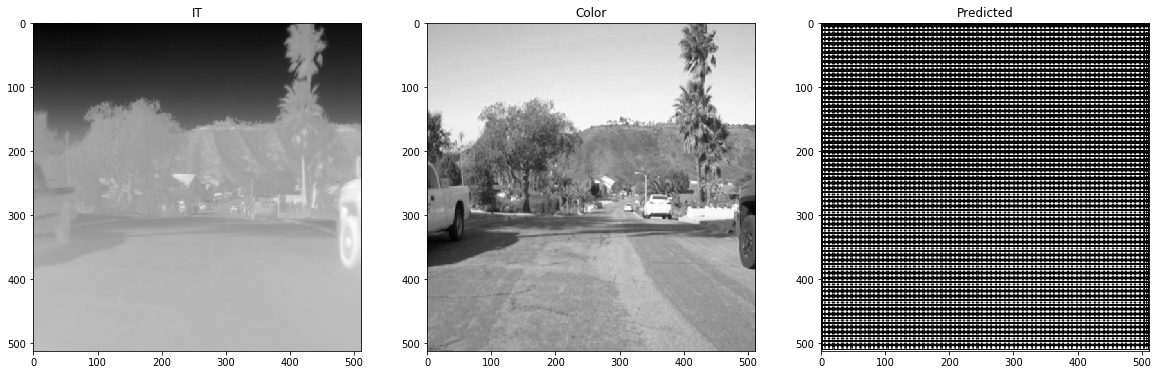

In [137]:
def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X)-1)

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    ax[0].set_title('IT')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Color')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted')
    
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train)
plot_sample(X_valid, y_valid, preds_val)

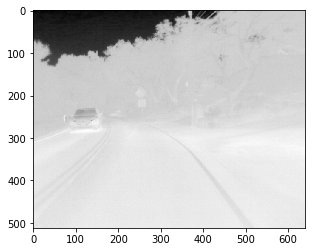

In [17]:
im2 = cv.imread('./IM/TRM/FLIR1.tiff',cv.COLOR_BGR2GRAY)
# im1 = cv2.resize(im1,im2.shape[:2])
imArr = np.array(im2)
imArr = (imArr - imArr.min()) / (imArr.max() - imArr.min())
plt.imshow(imArr);

In [6]:
ids_x = next(os.walk(path_train + "TRM", topdown=True))[2]
ids_y = next(os.walk(path_train + "RGB", topdown=True))[2]
ids_y.sort()
print(ids_y)

StopIteration: 

In [152]:
x = X_train[0,...,0]
im = cv.imdecode(x,1)
equ = cv.equalizeHist(im)
print(im)

None
